# Exercise session - Atmospheric structure
Guillaume Chaverot - guillaume.chaverot@unige.ch   
May 7, 2021

Observers are now able to detect different molecules in the atmopshere of exoplanets. Thanks to this, it is possible to use 3D climate models (Global Climate Models) or simpler 1D climate models to study the climate of exoplanets and thus their habitability. But keep in mind that "habitable" does not mean that Humans can live or travel there.  *''There is no planet B'' as Michel Mayor says !*

The first step in the study of the climate of a planet is to compute the atmopsheric profiles of that planet. These profiles are then used in 1D models to compute the radiative transfer of the atmopshere to obtain information on the absorbed and emitted fluxes. GCMs (3D models) also take into account the dynamics and other complex processes (advection, clouds, ocean etc...)

The aim of this exercise is to compute the pressure and temperature profiles of an atmosphere, assuming surface pressure and temperature. You have learned with David Ehrenreich what is a lapse rate and how compute it. Here, we will see how use it. 
First we will compute the profiles of a dry atmosphere. Then we will take into account the condensation of water to compute the profiles of a wet atmosphere. Finally we will produce profiles for a more general case where the atmopshere can be dry or wet depending on the temperature.

For simplicity we will study only one-component atmospheres. You will find with this notebook two python files: "phys.py" and "planets.py". The first one provides gas parameters for multiples gases and the second one provides planet parameters. See examples below to learn how to use these modules.
There are also data files which contain the real temperature vs pressure profile for different planets and moons (*Venus.dat*, *Earth.dat*, *Mars.dat*, *Jupiter.dat*, *Titan.dat*)

**To go further:**
Pierrehumbert R. T., 2010, *Principles of Planetary Climate*

In [1]:
%reset -f
%matplotlib inline
import  numpy as np
import  matplotlib.pyplot as plt

# Gas constant from Pierrhumbert (2010)
import phys

In [2]:
# Available gases: H2O, CH4, CO2, N2, O2, H2, He, NH3
# Example: 
print("H2O heat capacity = ", phys.H2O.cp)
print("CO2 triple point temperature = ", phys.CO2.TriplePointT)

H2O heat capacity =  1847.0
CO2 triple point temperature =  216.54


In [3]:
# Planet parameters from Pierrhumbert (2010)
import planets

# Available planets: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune
# Example: 
print("Earth radius = ", planets.Earth.a)
print("Mars gravitational acceleration = ", planets.Mars.g)

Earth radius =  6371000.0
Mars gravitational acceleration =  3.71


***==> Be carefull with units <==***

## I. Dry adiabat

First of all we need to define a pressure profile of our atmopshere. Pressure is a natural vertical coordinate and more general than altitude, because it does not depend on planetary parameters.
The first aim is therefore to define functions to compute the temperature profile relative to the pressure. Then we will be able to link the pressure coordinates to the altitude.

### I.A) Pressure profile

**Question:** Write a function to compute a pressure grid which follows a logarithmic distribution. In other words, the function must compute a grid of pressure values, where the boundary pressures and the number of levels are the parameters of the function. Make a figure of the pressure vs the atmopsheric levels and verify that the pressure follows a logarithmic function. We will assume a pressure of 1bar at the surface and 1Pa at the top of the atmopshere.

In [4]:
def set_P_profile(Ps, Ptop, nb_lvl):
    Ptop1, Ps1 = np.log10(Ptop), np.log10(Ps)
    ab = np.logspace(Ptop1, Ps1, nb_lvl)
    return np.flip(ab)

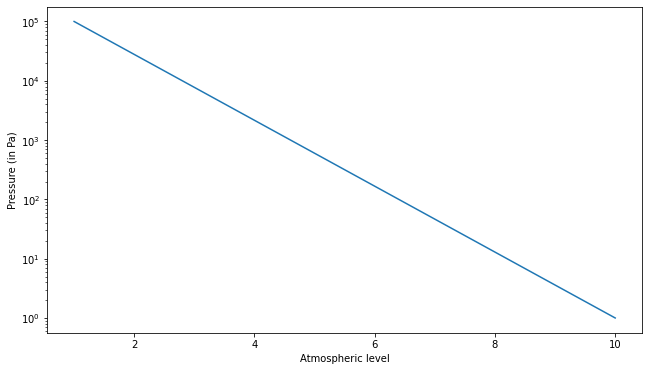

In [5]:
nos_lvls = 10000
levels = np.linspace(1, 10, nos_lvls)
p_prof = set_P_profile(1e5, 1, nos_lvls)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(levels, p_prof, label='Pressure profile')
plt.xlabel('Atmospheric level')
plt.ylabel('Pressure (in Pa)')
plt.yscale('log')
#plt.xscale('log')

### I.B) Temperature profile 
To compute the temperature profile we need the following two equations (see David Ehrenreich's lesson):

Dry adiabatic lapse rate:
$$\frac{dT}{dz}=-\frac{g}{c_p}$$

Hydrostatic equation:
$$\frac{dP}{dz}=-\rho g$$

**Questions**:     
1) Using the dry adiabatic lapse rate and the hydrostatic equation, find an equation to compute the temperature relative to the pressure: $T(P)$.

From both of above equations, $$\frac{dT}{dP} = -\frac{1}{c_p \rho}$$

Also, we know that, $p = \rho R T$, implementing this into previous equation,

$$\frac{dT}{dP} = \frac{RT}{c_p P}$$
$$\Rightarrow \frac{dT}{T} = \frac{R}{c_p}\frac{dP}{P}$$

Upon integrating this equation, we find that,

$$T(P) = \left(\frac{P}{P_0}\right)^{R/c_p} \times T_{surf}$$

2) Implement the obtained equation into a function *Tdry* to compute the temperature profile, knowing the pressure profile and the surface temperature. It should be useful to do not define the gas parameters in the function itself but through a variable, which is an object from the *phys.py* module, in your input parameters (*phys.H2O* for example).      
3) Then compute and make a figure of the temperature profile for the Earth's parameters.

In [6]:
### Example ###
def My_function(gas):
    print('Name = ',gas.name)
    print('R = ',gas.R)
    return

My_function(phys.H2O)
### -------------

Name =  Water
R =  461.9173324615943


In [15]:
def Tdry(P,Tsurf,gas):
    temp = (P/1e5)**(gas.R/gas.cp)*Tsurf
    return temp

(100000.0, 1.0)

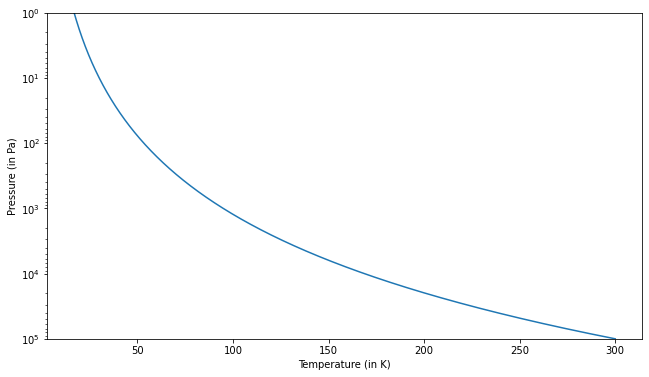

In [16]:
t_prof = Tdry(p_prof, 300, gas=phys.H2O)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(t_prof, p_prof, label='Temperature profile')
plt.ylabel('Pressure (in Pa)')
plt.xlabel('Temperature (in K)')
plt.yscale('log')
plt.ylim([np.max(p_prof), np.min(p_prof)])

The temperature tends to 0 for low pressures (< 1 Pa). A convenient way to solve this problem is to assume an isothermal stratosphere. In other words we assume that the temperature in the whole atmopshere cannot be lower than a limit value:

$$\mathrm{T \geq T_{stratosphere}}$$

For the earth the temperature in the stratosphere is about 200K. Other physical processes are involved in the upper atmopshere but we will not discuss them here.

**Question:** Write a new function *Tdry_corrected* to compute a dry adiabat with an isothermal stratosphere assuming *Tstrat*=200K. Make a figure with the new profile for the Earth and compare it to the real profile from the *Earth.dat* file.

In [35]:
def Tdry_corrected(P,Tsurf,Tstrat,gas):
    sb = Tdry(P,Tsurf,gas)
    tnew = np.zeros(len(sb))
    for i in range(len(sb)):
        if sb[i] < Tstrat:
            tnew[i] = sb[i] + Tstrat
        else:
            tnew[i] = sb[i]
    return tnew

(100000.0, 1.0)

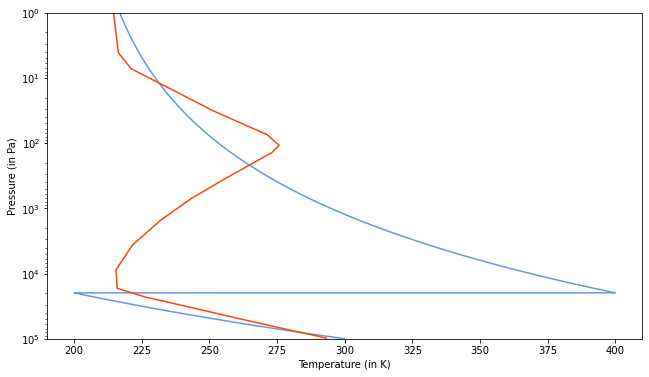

In [36]:
t_prof_new = Tdry_corrected(p_prof, Tsurf=300, Tstrat=200, gas=phys.H2O)
t_ear, p_ear1 = np.loadtxt('Earth.dat', usecols=(0,1), unpack=True)
p_ear = p_ear1*1e5

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(t_prof_new, p_prof, label='Simulated temperature profile', c='cornflowerblue')
plt.plot(t_ear, p_ear, label='Atmospheric structure of Earth', c='orangered')
plt.ylabel('Pressure (in Pa)')
plt.xlabel('Temperature (in K)')
plt.yscale('log')
plt.ylim([np.max(p_prof), np.min(p_prof)])


**Discussion:** Is our model accurate ? Why ? How improve it ?

### I.C) Tropopause height
The tropopause is the limit between the tropopshere and the stratosphere. It is an important quantity because the troposphere is the convective part of the atmosphere while the stratopshere is more "stable". 
To estimate the height of the tropopause, we must change our vertical coordinates to altitude. The aim of this part is to estimate the altitude of each atmospheric level.

**Questions:**    
1) Use the hydrostatic equation (available in the syllabus) to compute the temperature relative to altitude (not relative to pressure as previously) for the Earth and assuming a dry adiabat. To do this, you need write a function which uses the pressure and temperature grids to compute an altitude grid (z grid). Then make a T vs z figure. The functions written earlier should be useful.    
2) What is the height of the tropopause? Compare your value with the real value for the Earth computed using the *Earth.dat* data file. Discuss your estimate.


In [12]:
def grav(z, Mp, Rp):
    # ...
    return

def altitude(P, T, gas, planet):
    ''' Here "planet" is an object from the "planet.py" module '''
    # ...
    return

### I.D) Other planets (optional)

We can now compute the pressure and temperature profiles for a dry atmopshere. In this section we test our model with different planets and moons of the solar system. The planetary data are available in the file "planets.py". You must check the atmospheric composition of the planetary atmospheres to compute the temperature.

**Question:** Find and list the main component of the atmopshere for different planets and moons (Venus, Mercuy, Mars, Jupiter, Titan ...). Then compute a dry adiabatic profile for these objects and compare your results to reality (.dat files). Be careful with the units! You can modify the stratospheric temperature because it depends on the considered planet/moon.

**Discussion:** Is our model sufficient to accurately represent the temperature profile of the planets ? Are we able to accurately estimate the height of the tropopause ? Why ?



## II. Moist adiabat

In this section, we will consider the capacity of water to condense to improve our model. By decreasing the temperature in a moist atmopshere, water condenses and form clouds. But as clouds are a key problem in GCM and climate models in general, we will assume a pseudo-adiabatic hypothesis. Water is allowed to condense but the liquid part is immediatly removed by precipitation. In other words, for a given pressure, the water vapor temperature cannot be lower than the saturation temperature: 

$$\mathrm{T_{vapor}(P) \geq T_{saturation}(P)}$$

Where the saturation temperature $\mathrm{T_{saturation}}$ corresponds to the "boundary" between the liquid and vapor phase on the phase diagram.
Therefore, in a moist atmopshere, the water temperature is equal to the saturation temperature:

$$\mathrm{T_{moist}(P) = T_{saturation}(P)}$$

<img src="phase_diagram.png" alt="Phase diagram" width="450"/>

The relation between the saturation temperature and the pressure is given by the the Clausius-Clapeyron equation:

$$\mathrm{T_{saturation}(P)=\frac{1}{\frac{1}{T_0}\frac{R}{L}\ln\left(\frac{P}{P_0}\right)}}$$

With T$_0$ and P$_0$ the temperature and pressure of the triple point and L the latent heat of vaporization.

We use here the example of water to explain the moist adiabatic process but this is also valid for other condensable species like CO$_2$.

**Questions:**     
1) Use the Clausius-Clapeyron equation to write a function *Tmoist* which computes the temperature grid for a fully wet atmopshere. Make a figure of this moist adiabat for a waterworld with a surface pressure egal to 1bar. Notice that this moist adiabat does not depend on the surface temperature.    
2) In a second time compare the dry and the moist adiabats for the same surface temperature. How fast does the temperature decrease in both case?   
3) Then try to compute the temperature profile of the Earth using the moist adiabat. By doing that, we assume a water dominated atmopshere which is wrong. On Earth water is approximately 0.4% of the total volume of the atmosphere. What is the obtained surface temperature ? Explain.   

In [13]:
def Tmoist(P, gas):
    # ...
    return

## III. More realistic atmosphere

In the previous section, we assumed a fully saturated atmosphere but if the surface temperature is higher than the saturation temperature water cannot condense. In this case, the lower part of the atmosphere is dry. In the upper layers, the temperature decreases and water can condense.

The purpose of this section is to write a function which takes into account the condensability of gases to compute the thermal profile of an atmopshere. The key point to keep in mind is that for a given gas species and for a given species at a given pressure:

$$\mathrm{T(P) \geq T_{saturation}(P)}$$

This means that the surface temperature is defined as: $\mathrm{T_{surface}(P_{surface}) \geq T_{saturation}(P_{surface})}$.    
To summarize, in terms of *dry* and *wet* atmopsheric profiles:

$$\mathrm{T_{dry}(P) > T_{saturation}(P)}$$
$$\mathrm{T_{moist}(P) = T_{saturation}(P)}$$

**Questions:**    
1) Use previous functions to compute a mixed profile, with a dry part at the bottom and a moist part above. Make a figure with the thermal profile of a waterworld with *Tsurf*=500K and *Psurf*=2bar. Add the dry adiabat for same parameters on the same figure. Discuss it.   
2) In a second time, use Earth's parameters and compare the result to the the real Earth's profile. How is the temperature profile in the troposphere? Wet? Dry? Why?


In [14]:
def Tmixed(P,Psurf,Tsurf,Tstrat,gas): 
    # ...
    return

**Discussion:** How can we improve the model? What processes have we omited? 

